# Diffusion Process
The notebook demonstrates how to use the Diffusion Vivarium process as a stand-alone processes.

Diffusion does..

## imports

In [2]:
from processes.diffusion_field import DiffusionField
from plots.field import plot_fields_temporal
from vivarium.core.engine import Engine
from vivarium.plots.topology import plot_topology
from experiments.comets import test_comets
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import io
import base64
from IPython.display import display, HTML

## run a diffusion simulation

In [3]:
total_time = 200
config = {
    'bounds': [20, 20],
    'nbins': [20, 20],
    'molecules': ['glucose', 'oxygen'],
    'diffusion': {
        'glucose': 2.0E-2 ,    # 6.7E-6,  # cm^2/s
        'oxygen':  6.7E-1,     # 2.0E-5,  # cm^2/s
    },
    'advection': {
        'glucose': (0.01, 0.01),  # Advection vector for glucose
        'oxygen': (0.01, 0.01),   # Advection vector for oxygen
    },
    'sinking': {
        'glucose': -0.02,  # Sinks at a rate of 0.02 units per timestep
        'oxygen': -0.01,   # Sinks at a rate of 0.01 units per timestep
    }
}

# create the process and make a simulation
diffusion_field = DiffusionField(config)
initial_state = diffusion_field.initial_state({'random': 1.0})

sim = Engine(
    initial_state=initial_state,
    processes={'diffusion_process': diffusion_field},
    topology={'diffusion_process': {
        'fields': ('fields',),
        'species': ('species',),
        'dimensions': ('dimensions',),
    }}
)
# Run the simulation
sim.update(total_time)
# Get the results
data = sim.emitter.get_timeseries()


Simulation ID: 8649c5da-16bf-11ef-9fea-ba21c95c07d9
Created: 05/20/2024 at 11:42:11
Completed in 9.98 seconds


## show vivarium plot of the process

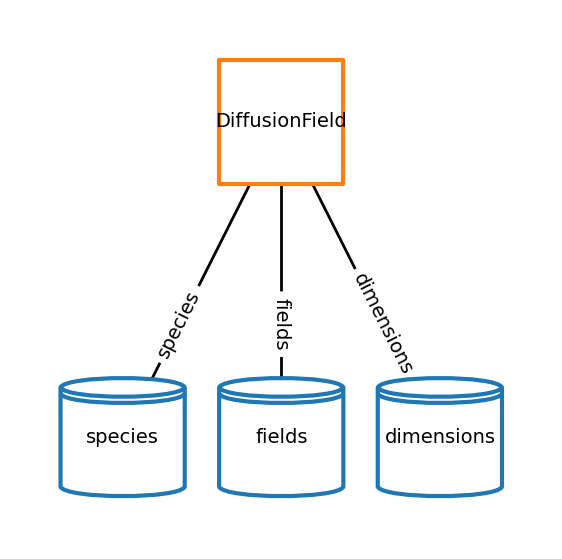

In [4]:
fig = plot_topology(diffusion_field)

In [5]:
data.keys()

dict_keys(['species', 'fields', 'dimensions', 'time'])

## print out the ports schema

In [6]:
diffusion_field.ports_schema()

{'species': {'Alteromonas': {'_default': array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
           1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 

## plot the data


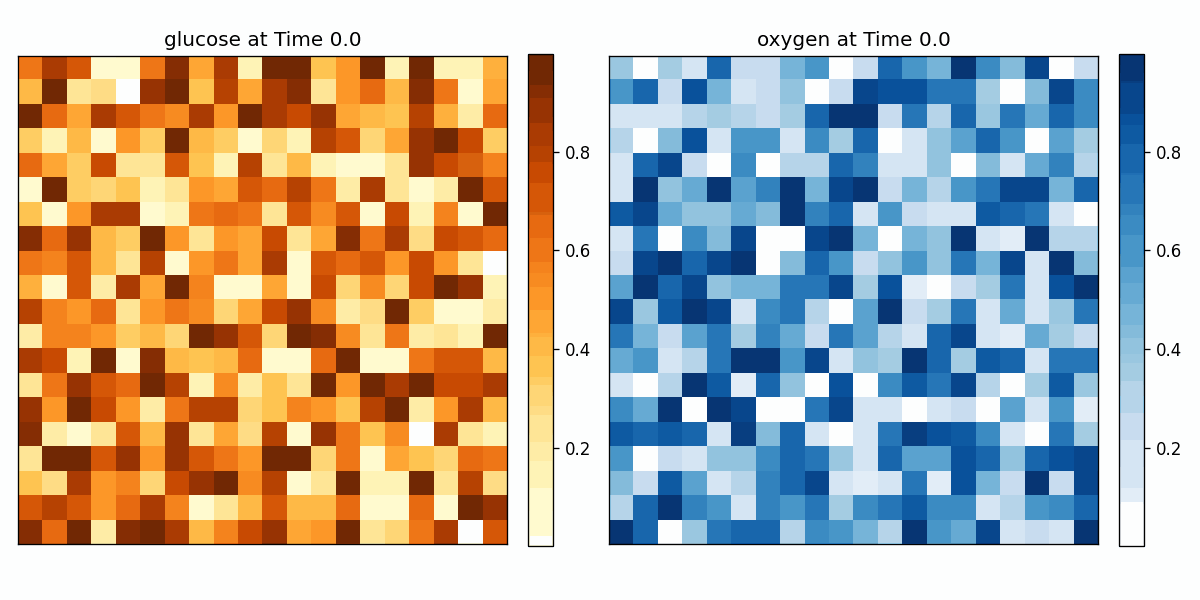

In [10]:
def plot_fields_temporal_to_gif(
        fields_data,
        desired_time_points,
        actual_time_points,
        filename='fields_over_time.gif',
        molecule_colormaps={'glucose': 'YlOrBr', 'oxygen': 'Blues'},  # Specify color maps for each molecule
        plot_fields=["glucose", "oxygen"],
        skip_frames=1
):
    if not os.path.exists('temp'):
        os.makedirs('temp', exist_ok=True)

    # Convert desired and actual time points to float for accurate indexing
    desired_time_points = [float(time) for time in desired_time_points]
    actual_time_points = [float(time) for time in actual_time_points]
    num_molecules = len(plot_fields)
    num_times = len(desired_time_points)
    images = []

    # Calculate global min/max for each molecule across all timepoints
    global_min_max = {}
    for molecule in fields_data.keys():
        if molecule not in plot_fields:
            continue
        all_data = np.concatenate([np.array(times_data) for times_data in fields_data[molecule]], axis=0)
        global_min_max[molecule] = (np.min(all_data), np.max(all_data))

    for time_idx, desired_time in enumerate(desired_time_points):
        if desired_time in actual_time_points:
            actual_idx = actual_time_points.index(desired_time)
            fig, axs = plt.subplots(1, num_molecules, figsize=(10, 5), squeeze=False)

            for mol_idx, molecule in enumerate(plot_fields):
                data_array = np.array(fields_data[molecule][actual_idx])  # Accessing the time-specific data
                ax = axs[0, mol_idx]
                cmap = molecule_colormaps.get(molecule, 'viridis')  # Default to 'viridis' if molecule not in dict
                vmin, vmax = global_min_max[molecule]  # Use global min/max
                cax = ax.imshow(data_array, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
                ax.set_title(f'{molecule} at Time {desired_time}', fontsize=12)
                ax.set_xticks([])
                ax.set_yticks([])
                # Add a colorbar for each subplot
                cb = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
                cb.ax.tick_params(labelsize=10)

            plt.tight_layout()
            buf = io.BytesIO()
            plt.savefig(buf, format='png', dpi=120)
            buf.seek(0)
            images.append(imageio.imread(buf))
            buf.close()
            plt.close(fig)

    # Create and save the GIF with loop=0 for infinite loop
    imageio.mimsave(filename, images, duration=0.5, loop=0)

    # Optionally display the GIF in a Jupyter notebook
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    display(HTML(f'<img src="{data_url}" alt="Fields Over Time" style="max-width:100%;"/>'))

# Example usage
#total_time = 100  # You should define this variable based on your actual data
time_list = [i for i in range(total_time)]

plot_fields_temporal_to_gif(
    data['fields'], 
    desired_time_points=time_list, 
    actual_time_points=time_list, 
    filename='fields_over_time.gif'
)

def display_gif(filename):
    with open(filename, 'rb') as file:
        data = file.read()
        data_url = 'data:image/gif;base64,' + base64.b64encode(data).decode()
    html_str = f'<img src="{data_url}" alt="Fields Over Time" style="max-width:100%;"/><br/>'
    html_str += f'<a href="{data_url}" download="{filename}">Download GIF</a>'
    display(HTML(html_str))

# Just to download the file'
#display_gif('fields_over_time.gif')